In [1]:
import pandas as pd
from sklearn.model_selection import cross_val_score, TimeSeriesSplit

data = pd.read_csv(
    'https://raw.githubusercontent.com/Garve/datasets/4576d323bf2b66c906d5130d686245ad205505cf/mmm.csv',
    parse_dates=['Date'],
    index_col='Date'
)

X = data.drop(columns=['Sales'])
y = data['Sales']

In [2]:
from mamimo.datasets import load_fake_mmm

data = load_fake_mmm()

X = data.drop(columns=['Sales'])
y = data['Sales']

In [5]:
from mamimo.time_utils import add_time_features, add_date_indicators


X = (X
     .pipe(add_time_features, month=True)
     .pipe(add_date_indicators, special_date=["2020-01-05"])
     .assign(trend=range(200))
)

In [6]:
from mamimo.time_utils import PowerTrend
from mamimo.carryover import ExponentialCarryover
from mamimo.saturation import ExponentialSaturation
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

cats =  [list(range(1, 13))] # different months, known beforehand

preprocess = ColumnTransformer(
    [
     ('tv_pipe', Pipeline([
            ('carryover', ExponentialCarryover()),
            ('saturation', ExponentialSaturation())
     ]), ['TV']),
     ('radio_pipe', Pipeline([
            ('carryover', ExponentialCarryover()),
            ('saturation', ExponentialSaturation())
     ]), ['Radio']),
     ('banners_pipe', Pipeline([
            ('carryover', ExponentialCarryover()),
            ('saturation', ExponentialSaturation())
     ]), ['Banners']),
    ('month', OneHotEncoder(sparse=False, categories=cats), ['month']),
    ('trend', PowerTrend(), ['trend']),
    ('special_date', ExponentialCarryover(), ['special_date'])
    ]
)

model = Pipeline([
    ('preprocess', preprocess),
    ('regression', LinearRegression(
        positive=True,
        fit_intercept=False # no intercept because of the months
        ) 
    )
])

In [7]:
from scipy.stats import randint, uniform
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit

tuned_model = RandomizedSearchCV(
    model,
    param_distributions={
        'preprocess__tv_pipe__carryover__window': randint(1, 10),
        'preprocess__tv_pipe__carryover__strength': uniform(0, 1),
        'preprocess__tv_pipe__saturation__exponent': uniform(0, 1),
        'preprocess__radio_pipe__carryover__window': randint(1, 10),
        'preprocess__radio_pipe__carryover__strength': uniform(0, 1),
        'preprocess__radio_pipe__saturation__exponent': uniform(0, 1),
        'preprocess__banners_pipe__carryover__window': randint(1, 10),
        'preprocess__banners_pipe__carryover__strength': uniform(0, 1),
        'preprocess__banners_pipe__saturation__exponent': uniform(0, 1),
        'preprocess__trend__power': uniform(0, 2),           
        'preprocess__special_date__window': randint(1, 10),  
        'preprocess__special_date__strength': uniform(0, 1), 
    },
    cv=TimeSeriesSplit(),
    random_state=0,
    n_iter=1000, # can take some time, lower number for faster results
)

tuned_model.fit(X, y)

print(tuned_model.best_params_)

c:\Program Files\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Program Files\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Program Files\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Program Files\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed 

{'preprocess__banners_pipe__carryover__strength': 0.9803750792296568, 'preprocess__banners_pipe__carryover__window': 1, 'preprocess__banners_pipe__saturation__exponent': 0.17633290746448915, 'preprocess__radio_pipe__carryover__strength': 0.9417421432655166, 'preprocess__radio_pipe__carryover__window': 1, 'preprocess__radio_pipe__saturation__exponent': 0.06918480469264277, 'preprocess__special_date__strength': 0.8667029791268241, 'preprocess__special_date__window': 6, 'preprocess__trend__power': 1.463860555363072, 'preprocess__tv_pipe__carryover__strength': 0.3422263312509606, 'preprocess__tv_pipe__carryover__window': 1, 'preprocess__tv_pipe__saturation__exponent': 0.3591065076533001}


c:\Program Files\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Program Files\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Program Files\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Program Files\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed 

In [8]:
from mamimo.analysis import breakdown

contributions = breakdown(tuned_model.best_estimator_, X, y)

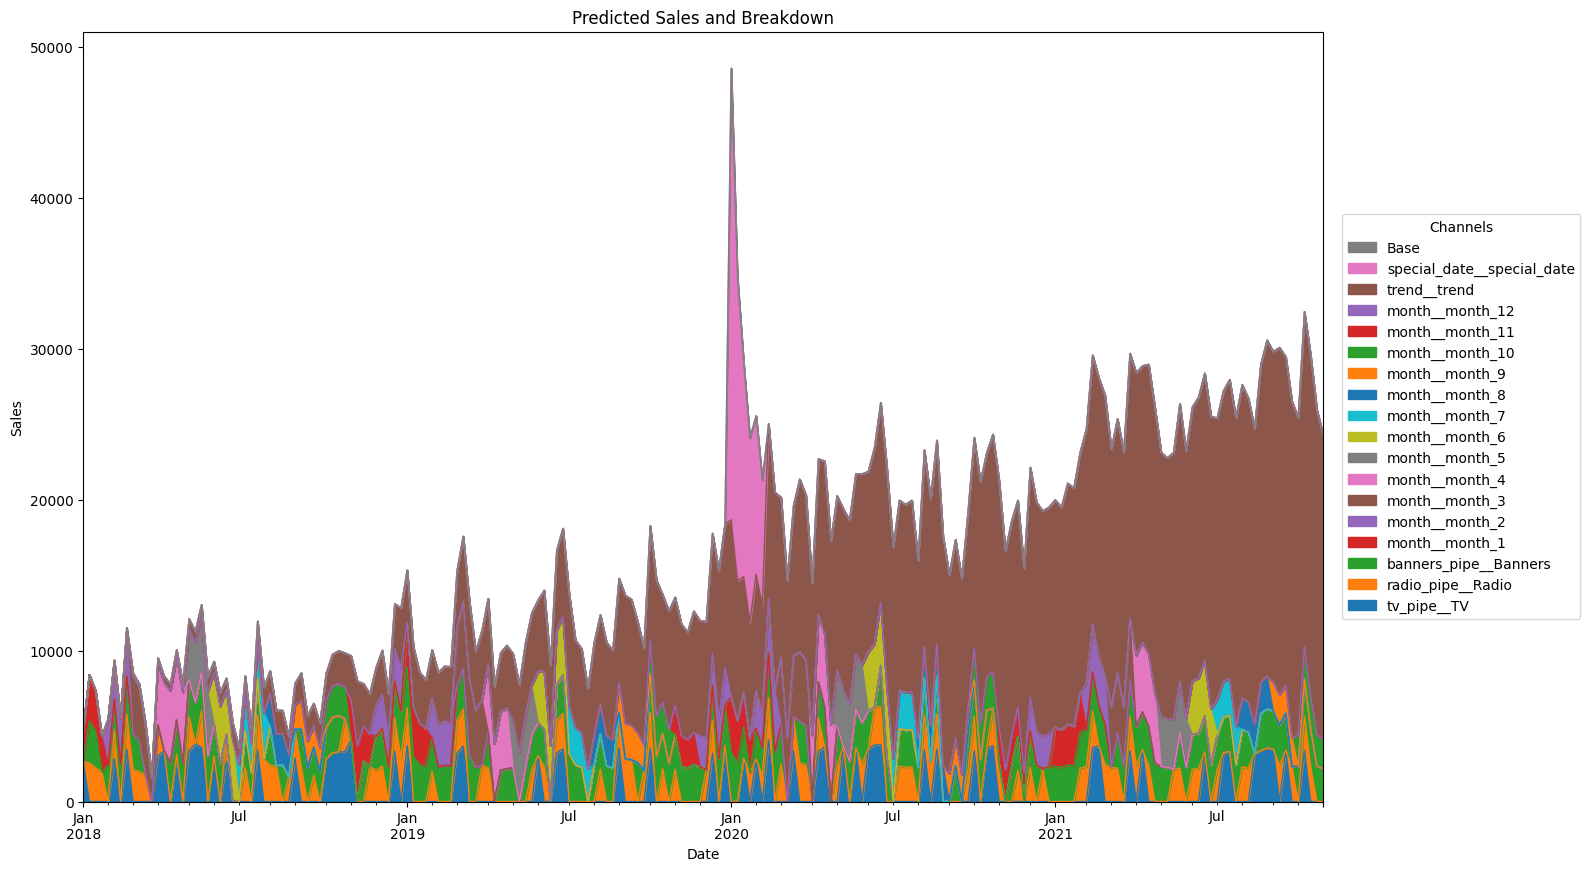

In [10]:
ax = contributions.plot.area(
    figsize=(16, 10),
    linewidth=1,
    title="Predicted Sales and Breakdown",
    ylabel="Sales",
    xlabel="Date",
)
handles, labels = ax.get_legend_handles_labels()
ax.legend(
    handles[::-1],
    labels[::-1],
    title="Channels",
    loc="center left",
    bbox_to_anchor=(1.01, 0.5),
)

In [11]:
group_channels = {'Baseline': [f'month__month_{i}' for i in range(1, 13)] + ['Base', 'trend__trend']} 
# read: 'Baseline consists of the months, base and trend.'
# You can add more groups!

contributions = breakdown(
    tuned_model.best_estimator_,
    X,
    y,
    group_channels
)

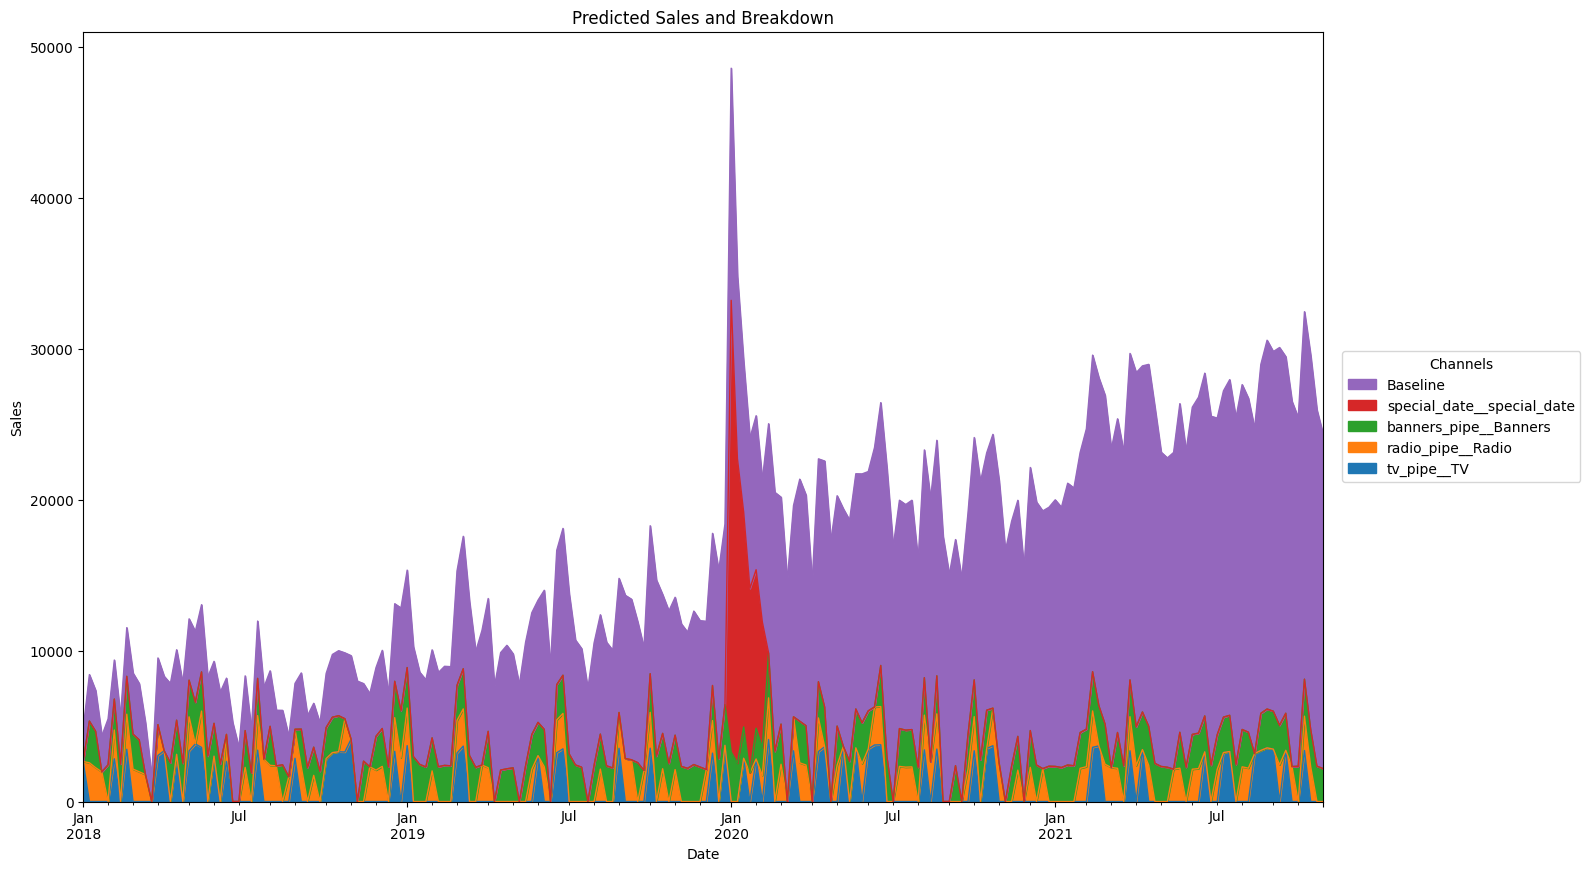

In [12]:
ax = contributions.plot.area(
    figsize=(16, 10),
    linewidth=1,
    title="Predicted Sales and Breakdown",
    ylabel="Sales",
    xlabel="Date",
)
handles, labels = ax.get_legend_handles_labels()
ax.legend(
    handles[::-1],
    labels[::-1],
    title="Channels",
    loc="center left",
    bbox_to_anchor=(1.01, 0.5),
)